# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook d'analyse exploratoire</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook d’exploration comprenant une analyse univariée, une analyse multivariée, une réduction dimensionnelle et les différentes questions de recherche associées (non cleané, pour comprendre votre démarche).

## <font color="#114b98">Sommaire</font>
[1. Chargement des jeux de données](#section_1)

[2. Analyse univariée](#section_2)  

[3. Analyse multivariée](#section_3)  

[4. Nettoyage de la colonne 'Tags'](#section_4)  

[5. Nettoyage de la colonne 'Text'](#section_5)  

## <font color="#114b98" id="section_1">1. Chargement des jeux de données</font>

In [59]:
import os
import re
import lxml
import nltk
import dill
import spacy
import gensim
import html5lib
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import datetime as dt
from typing import List
from nltk import pos_tag
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import STOPWORDS

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

%matplotlib inline
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [61]:
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=18)
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

J'ai tout d'abord réalisé la requête SQL suivante sur "StackExchange Data Explorer" afin de récuperer les données.
https://data.stackexchange.com/stackoverflow/queries

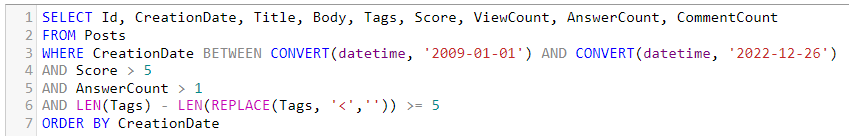

Je recevais 50000 réponses, ce qui est le maximum possible par requête sur ce site.

J'ai donc décidé de réaliser plusieurs requêtes avec des intervalles de temps de deux ans.

In [62]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
files = os.listdir(main_path+'ressources/')
files

['QueryResults 01012009-31122010.csv',
 'QueryResults 01012011-31122012.csv',
 'QueryResults 01012013-31122014.csv',
 'QueryResults 01012015-31122016.csv',
 'QueryResults 01012017-31122018.csv',
 'QueryResults 01012019-31122020.csv',
 'QueryResults 01012021-26122022.csv']

Nous avons à notre disposition 7 jeux de données.

Je crée un dictionnaire dans lequel je range les noms des jeux de données en clefs et leurs contenus dans les valeurs.

In [63]:
%%time
datasets = {}
for i, filename in enumerate(files):
    datasets[i] = pd.read_csv(main_path+'ressources/'+filename, 
                              parse_dates=['CreationDate'],
                              na_values = 'NaN')

Wall time: 3.24 s


In [64]:
data = pd.DataFrame()

In [65]:
for n in range(len(datasets)):
    data = pd.concat([data, datasets[n]])

In [66]:
data.shape

(159599, 9)

In [67]:
data.head()

,Id,CreationDate,Title,Body,Tags,Score,ViewCount,AnswerCount,CommentCount
0,404421,2009-01-01 02:26:41,How do I get a scheme interpreter working insi...,<p>I'm going through SICP and I'd like to have...,<macos><emacs><scheme><interpreter><sicp>,16,9877,5,0
1,404899,2009-01-01 12:23:25,Scope of variables in a delegate,<p>I found the following rather strange. Then ...,<c#><functional-programming><delegates><lambda...,8,7989,6,0
2,404941,2009-01-01 13:25:37,"How can I pass an ""array"" of values to my stor...","<p>I want to be able to pass an ""array"" of val...",<mysql><database><arrays><postgresql><stored-p...,14,43638,7,0
3,405134,2009-01-01 16:45:13,Manually setting a UIButton state,<p>I <code>UIButton</code> using + <code>butto...,<ios><objective-c><iphone><cocoa-touch><uibutton>,20,47489,7,1
4,405359,2009-01-01 19:38:10,Should I check for DB constraints in code or s...,<p>I have an application that saves data into ...,<database><nhibernate><exception-handling><con...,20,3731,8,0


Je crée une nouvelle variable "Text" dans laquelle je joins les données des variables "Titre" et "Body".

In [68]:
data['Texts'] = data.apply(lambda x: x['Title'] + ' ' + x['Body'] if x['Title'] == x['Title'] else x['Body'], axis=1)

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159599 entries, 0 to 2669
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Id            159599 non-null  int64         
 1   CreationDate  159599 non-null  datetime64[ns]
 2   Title         159599 non-null  object        
 3   Body          159599 non-null  object        
 4   Tags          159599 non-null  object        
 5   Score         159599 non-null  int64         
 6   ViewCount     159599 non-null  int64         
 7   AnswerCount   159599 non-null  int64         
 8   CommentCount  159599 non-null  int64         
 9   Texts         159599 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 13.4+ MB


In [70]:
data.duplicated().sum()

0

In [71]:
data.isna().sum()

Id              0
CreationDate    0
Title           0
Body            0
Tags            0
Score           0
ViewCount       0
AnswerCount     0
CommentCount    0
Texts           0
dtype: int64

In [72]:
data.reset_index(inplace=True, drop=True)

## <font color="#114b98" id="section_2">2. Analyse univariée</font>

In [73]:
data["CreationDate_year"] = data["CreationDate"].map(lambda y: y.year)
questions_per_year = data["CreationDate_year"].value_counts()

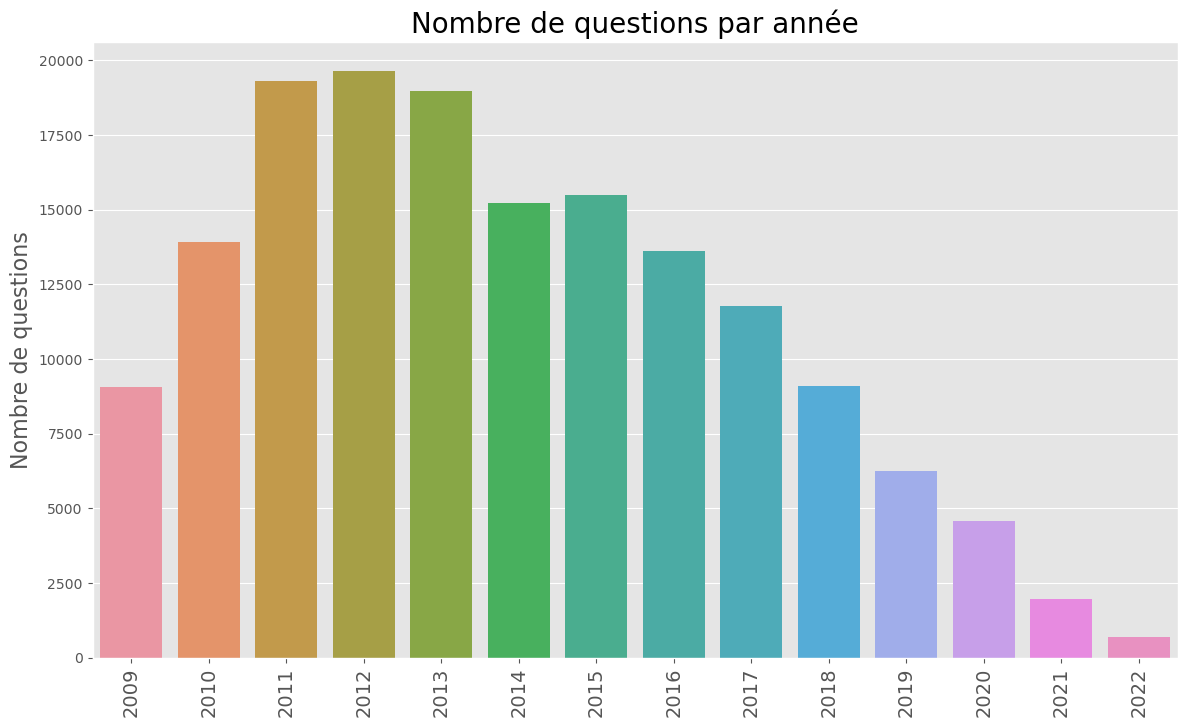

In [74]:
fig = plt.figure(figsize=(14, 8))
sns.barplot(x=questions_per_year.index, y=questions_per_year.values)
plt.title("Nombre de questions par année", size=20)
plt.xticks(rotation=90, size=14)
plt.ylabel("Nombre de questions", size=16)
plt.show()

La tendance globale à la baisse est logique. Je me suis limité aux questions qui ont des réponses et un bon score. 

Plus une question est ancienne, plus elle a eu le temps d'être lue, commentée, et de recevoir un score positif si elle le mérite.

In [75]:
data["CreationDate_month"] = data["CreationDate"].map(lambda m: m.month)

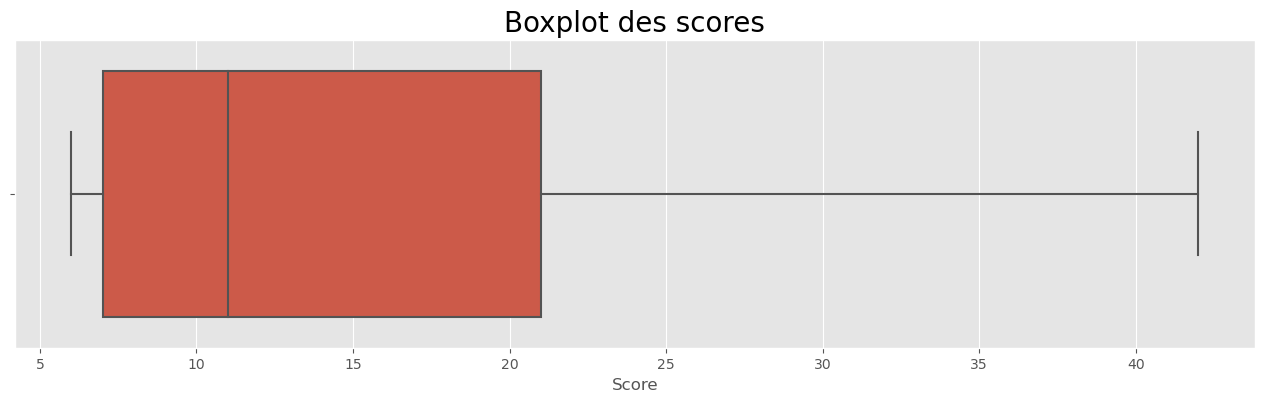

In [76]:
fig = plt.figure(figsize=(16, 4))
plt.title('Boxplot des scores',
          titleprops)
sns.boxplot(data=data, x="Score", showfliers=False)

plt.show()

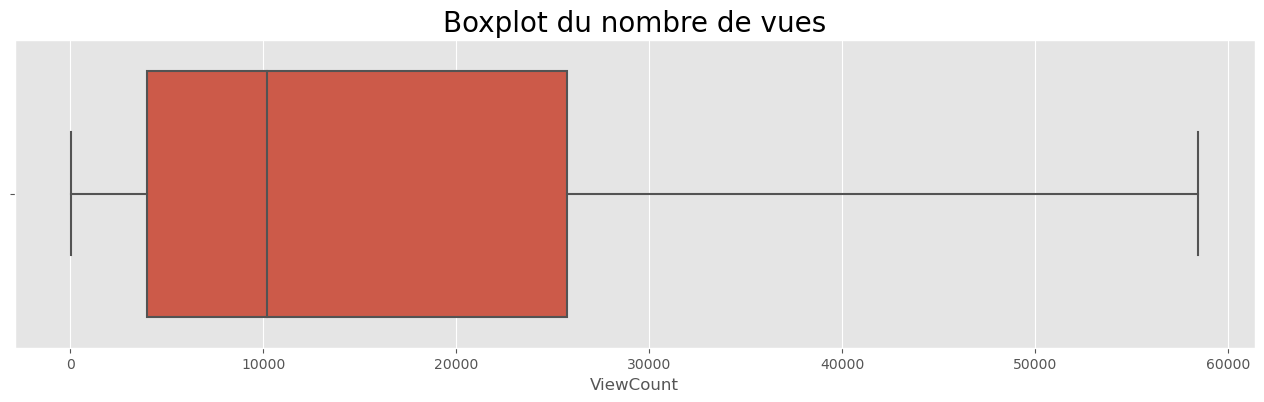

In [77]:
fig = plt.figure(figsize=(16, 4))
plt.title('Boxplot du nombre de vues',
          titleprops)
sns.boxplot(data=data, x="ViewCount", showfliers=False)

plt.show()

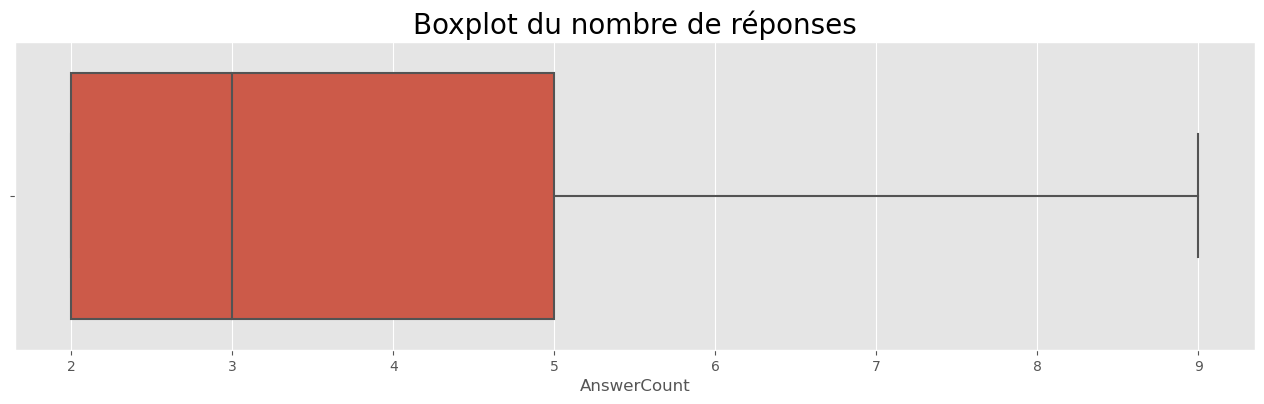

In [78]:
fig = plt.figure(figsize=(16, 4))
plt.title('Boxplot du nombre de réponses',
          titleprops)
sns.boxplot(data=data, x="AnswerCount", showfliers=False)

plt.show()

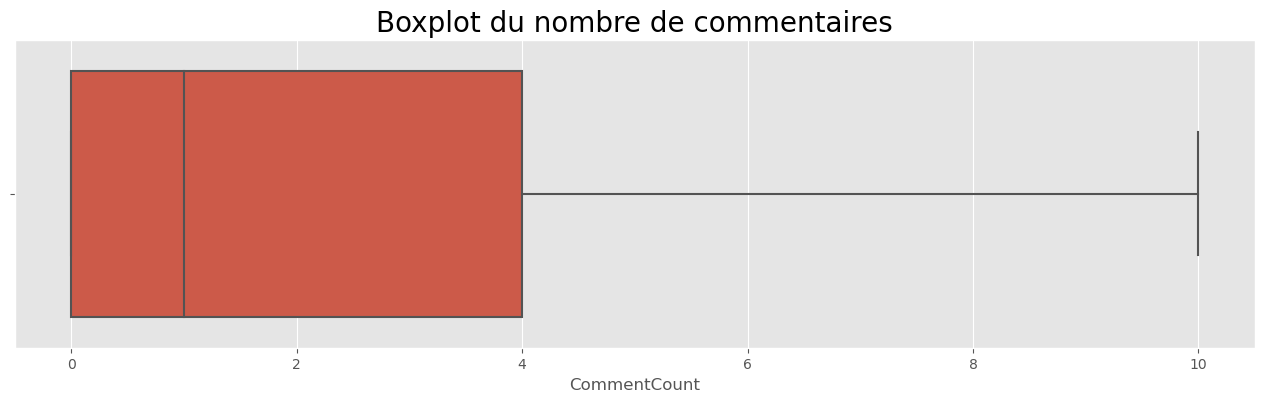

In [79]:
fig = plt.figure(figsize=(16, 4))
plt.title('Boxplot du nombre de commentaires',
          titleprops)
sns.boxplot(data=data, x="CommentCount", showfliers=False)

plt.show()

## <font color="#114b98" id="section_3">3. Analyse multivariée</font>

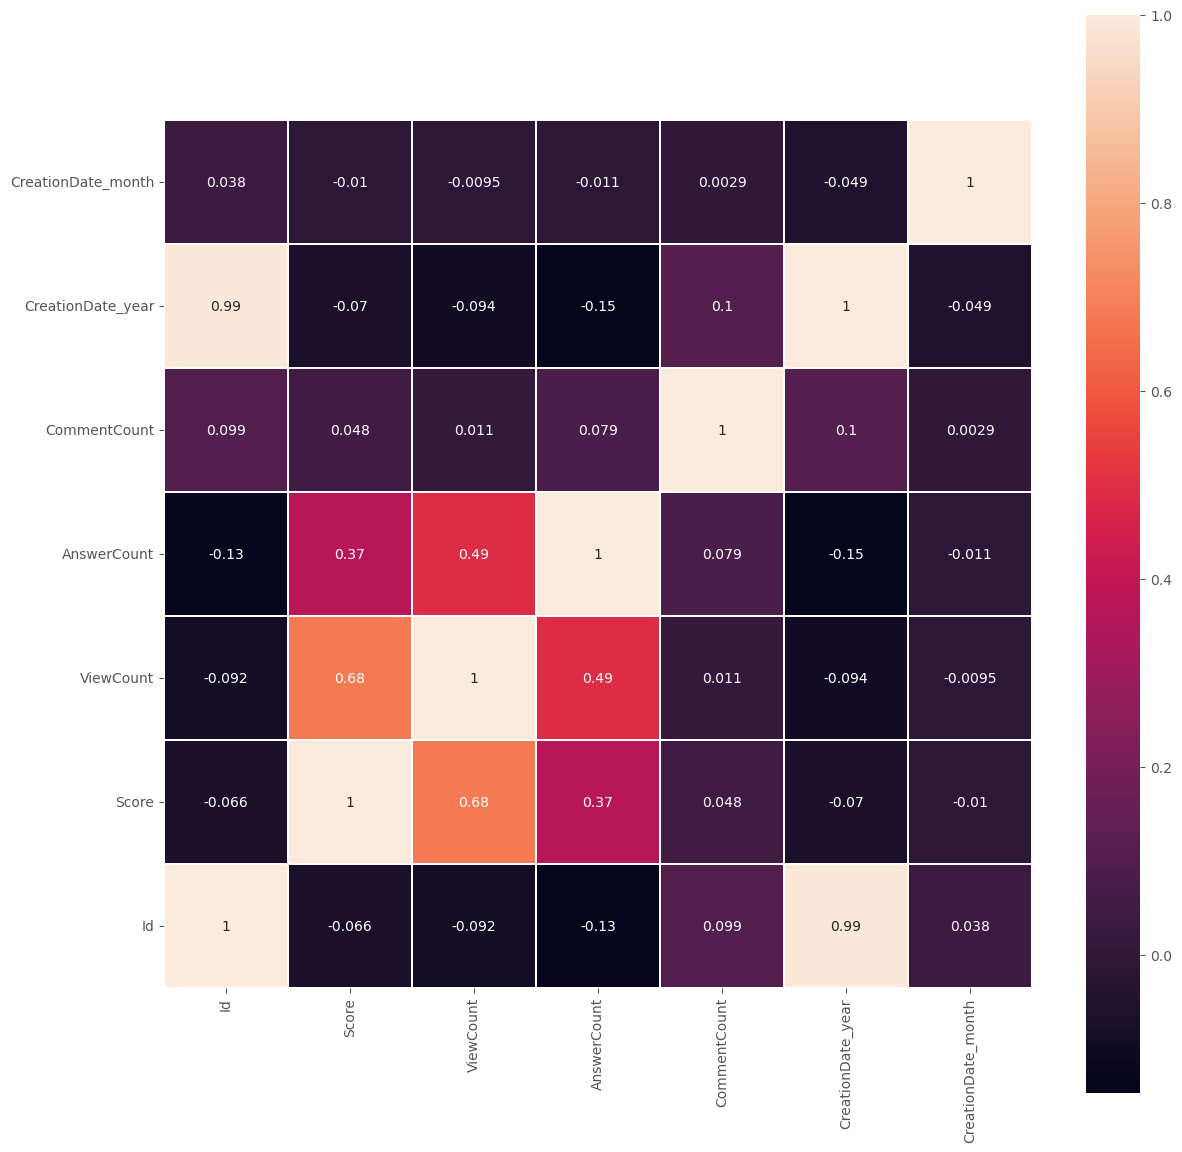

In [80]:
corr_matrix = data.corr()
fig = plt.figure(1, figsize=(14, 14))
sns.heatmap(corr_matrix, square=True, linewidths=0.1, annot=True)
plt.xlim(0, corr_matrix.shape[1])
plt.ylim(0, corr_matrix.shape[0])
plt.show()

La corrélation entre le nombre de vues et le score est normale.

Une question bien notée a davantage de chance d'être pertinente et qu'un grand nombre de personne la consulte.

In [81]:
data.columns

Index(['Id', 'CreationDate', 'Title', 'Body', 'Tags', 'Score', 'ViewCount',
       'AnswerCount', 'CommentCount', 'Texts', 'CreationDate_year',
       'CreationDate_month'],
      dtype='object')

In [82]:
data.drop(columns=['Id',
                   'CreationDate',
                   'Score',
                   'ViewCount',
                   'AnswerCount',
                   'CommentCount',
                   'CreationDate_year',
                   'CreationDate_month',
                   'Body',
                   'Title'],
          inplace=True)

In [83]:
print(f"Observations dans le corpus : {data.shape[0]}")

Observations dans le corpus : 159599


In [84]:
data.head()

,Tags,Texts
0,<macos><emacs><scheme><interpreter><sicp>,How do I get a scheme interpreter working insi...
1,<c#><functional-programming><delegates><lambda...,Scope of variables in a delegate <p>I found th...
2,<mysql><database><arrays><postgresql><stored-p...,"How can I pass an ""array"" of values to my stor..."
3,<ios><objective-c><iphone><cocoa-touch><uibutton>,Manually setting a UIButton state <p>I <code>U...
4,<database><nhibernate><exception-handling><con...,Should I check for DB constraints in code or s...


## <font color="#114b98" id="section_4">4. Nettoyage de la colonne 'Tags'</font>

In [85]:
data['Tags'][0:5]

0            <macos><emacs><scheme><interpreter><sicp>
1    <c#><functional-programming><delegates><lambda...
2    <mysql><database><arrays><postgresql><stored-p...
3    <ios><objective-c><iphone><cocoa-touch><uibutton>
4    <database><nhibernate><exception-handling><con...
Name: Tags, dtype: object

Les tags sont encadrés par des balises "<" et ">".

In [86]:
data['Tags'][0][1:-1].split('><')

['macos', 'emacs', 'scheme', 'interpreter', 'sicp']

In [87]:
data['Tags'] = data['Tags'].apply(lambda row: row[1:-1].split('><'))

In [88]:
tags = []
for minilist in data['Tags']:
    for item in minilist:
        item = item.lower()
        tags.append(item)

In [89]:
tag_counts = Counter(tags)
num_unique_tags = len(tag_counts.keys())
print('Nombre de tags uniques :', num_unique_tags) 

Nombre de tags uniques : 27357


In [90]:
temp_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['count'])
plot_df = temp_df.sort_values('count', ascending=False).head(20)

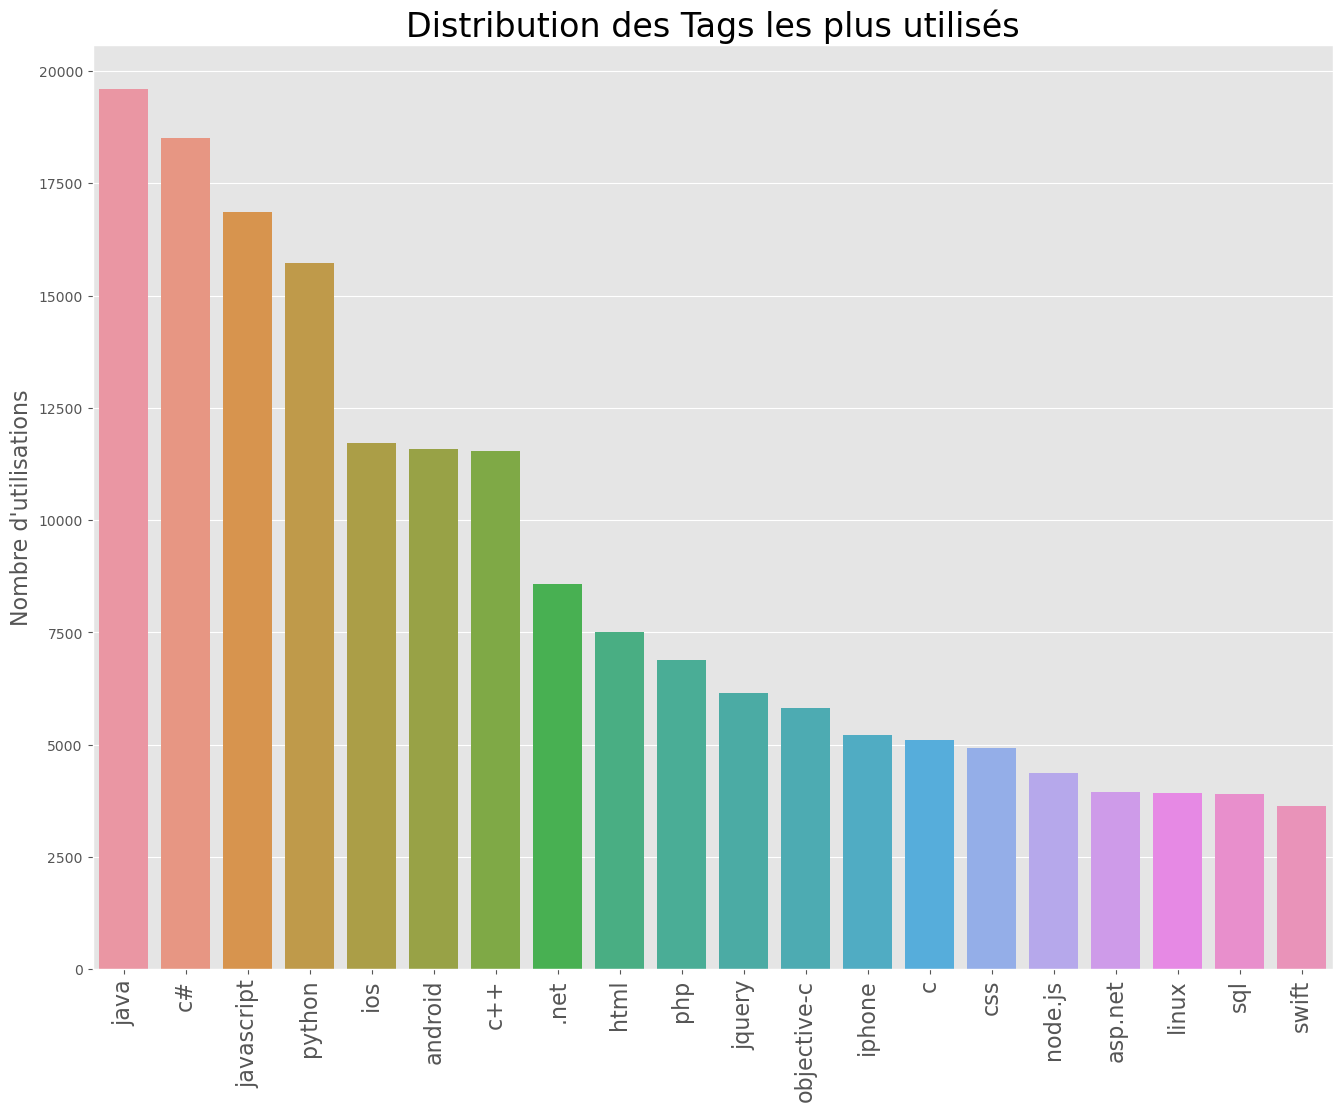

In [91]:
fig = plt.figure(figsize=(16, 12))
sns.barplot(x=plot_df.index, y=plot_df['count'])
plt.title("Distribution des Tags les plus utilisés", size=24)
plt.xticks(rotation=90, size=16)
plt.ylabel("Nombre d'utilisations", size=16)
plt.show()

In [92]:
colors = sns.color_palette('hls', n_colors=20)
color_dict = {word: f'#{int(rgb[0]*255):02x}{int(rgb[1]*255):02x}{int(rgb[2]*255):02x}' for rgb, word in zip(colors, plot_df.index)}

In [93]:
import random

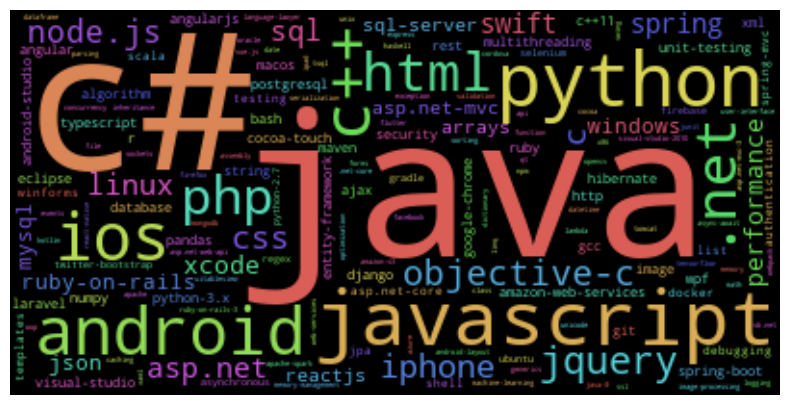

In [94]:
def get_color(word, **kwargs):
    if word in color_dict:
        return color_dict[word]
    else:
        return random.choice(list(color_dict.values()))

wordcloud = WordCloud(color_func=get_color).generate_from_frequencies(tag_counts)
plt.figure(figsize=[12, 5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [95]:
data['Tags'].head()

0            [macos, emacs, scheme, interpreter, sicp]
1    [c#, functional-programming, delegates, lambda...
2    [mysql, database, arrays, postgresql, stored-p...
3    [ios, objective-c, iphone, cocoa-touch, uibutton]
4    [database, nhibernate, exception-handling, con...
Name: Tags, dtype: object

## <font color="#114b98" id="section_5">5. Nettoyage de la colonne 'Texts'</font>

In [96]:
# Nettoyage des balises HTML
def clean_html(text):
    soup = BeautifulSoup(text, "html5lib")
    for sent in soup(['style', 'script']):
        sent.decompose()
    return ' '.join(soup.stripped_strings)


# Nettoyage du texte
def clean_text(text):
    pattern = re.compile(r'[^\w]|[\d_]')
    res = re.sub(pattern, " ", text)
    res = " ".join(word for word in res.split() if len(word) >= 3)
    return res


# Tokenisation et retrait des stopwords
nltk_stopwords = set(stopwords.words('english'))
gensim_stopwords = set(STOPWORDS)
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = set(nlp.Defaults.stop_words)
stop_words = nltk_stopwords.union(gensim_stopwords, spacy_stopwords)
# Adding some words I was getting in my models
stop_words.update(['way', 'use', 'page', 'project',
                   'die', 'yyyy', 'good', 'not', 'better'])

with open(main_path + 'streamlit-app/ressources/stop_words.pkl', 'wb') as f:
    dill.dump(stop_words, f)


def tokenize(text):
    tokens = word_tokenize(text, language='english')
    return [token for token in tokens if token not in stop_words]


# POS Tagging
def filtering_nouns(tokens):
    tagged_tokens = pos_tag(tokens)
    res = [token for token, tag in tagged_tokens if tag.startswith('N') or tag.startswith('PR')]
    return res

# Lemmatisation
def lemmatization(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [97]:
data['Texts'][0]

"How do I get a scheme interpreter working inside Emacs? <p>I'm going through SICP and I'd like to have an interpreter analogous to the interactive Python interpreter to play around in while I'm watching the lectures and reading the book. Furthermore, I'd like this interpreter to run inside Emacs so I can jump back and forth between files of scheme code and the interactive interpreter and so forth.</p>\n\n<p>However, I'm fairly new to Emacs and have not as of yet been able to get this to work or find one clear set of instructions to use in getting it to work.</p>\n\n<p>It seems like I should be able to set it up so that <code>M-x run-scheme</code> will open up an interactive interpreter that at least sounds like exactly what I want, but at the moment this just returns <code>Searching for program: no such file or directory, scheme</code> and I haven't been able to figure out exactly what files I need to put where to remedy this.</p>\n\n<p>I'm running <code>GNU Emacs 22.1.1 (mac-apple-da

Je passe tout d'abord tous les textes en lettres minuscules.

In [98]:
data['Texts'] = data['Texts'].str.lower()
data['Texts'][0]

"how do i get a scheme interpreter working inside emacs? <p>i'm going through sicp and i'd like to have an interpreter analogous to the interactive python interpreter to play around in while i'm watching the lectures and reading the book. furthermore, i'd like this interpreter to run inside emacs so i can jump back and forth between files of scheme code and the interactive interpreter and so forth.</p>\n\n<p>however, i'm fairly new to emacs and have not as of yet been able to get this to work or find one clear set of instructions to use in getting it to work.</p>\n\n<p>it seems like i should be able to set it up so that <code>m-x run-scheme</code> will open up an interactive interpreter that at least sounds like exactly what i want, but at the moment this just returns <code>searching for program: no such file or directory, scheme</code> and i haven't been able to figure out exactly what files i need to put where to remedy this.</p>\n\n<p>i'm running <code>gnu emacs 22.1.1 (mac-apple-da

Le texte comporte des balises HTML que je souhaite effacer.

In [99]:
data['Texts'] = data['Texts'].apply(clean_html)
data['Texts'][0]

"how do i get a scheme interpreter working inside emacs? i'm going through sicp and i'd like to have an interpreter analogous to the interactive python interpreter to play around in while i'm watching the lectures and reading the book. furthermore, i'd like this interpreter to run inside emacs so i can jump back and forth between files of scheme code and the interactive interpreter and so forth. however, i'm fairly new to emacs and have not as of yet been able to get this to work or find one clear set of instructions to use in getting it to work. it seems like i should be able to set it up so that m-x run-scheme will open up an interactive interpreter that at least sounds like exactly what i want, but at the moment this just returns searching for program: no such file or directory, scheme and i haven't been able to figure out exactly what files i need to put where to remedy this. i'm running gnu emacs 22.1.1 (mac-apple-darwin, carbon version 1.6.0) as installed through the os x 10.5 in

In [100]:
data['Sentences'] = data['Texts']

Je vais conserver uniquement les caractères alphabétiques et supprimer les mots de moins de trois lettres, même si cela va éliminer aussi des informations qui auraient été pertinentes (C, C#, C++, R, ...).

In [101]:
data['Texts'] = data['Texts'].apply(clean_text)
data['Texts'][0]

'how get scheme interpreter working inside emacs going through sicp and like have interpreter analogous the interactive python interpreter play around while watching the lectures and reading the book furthermore like this interpreter run inside emacs can jump back and forth between files scheme code and the interactive interpreter and forth however fairly new emacs and have not yet been able get this work find one clear set instructions use getting work seems like should able set that run scheme will open interactive interpreter that least sounds like exactly what want but the moment this just returns searching for program such file directory scheme and haven been able figure out exactly what files need put where remedy this running gnu emacs mac apple darwin carbon version installed through the install dvd'

Je vais maintenant tokeniser afin de transformer les textes en listes de termes distincts (tokens). 

J'élimine aussi les termes génériques anglais (stop words) afin de n'avoir que des mots pertinents.

In [102]:
data['Texts'] = data['Texts'].apply(tokenize)
data['Texts'][0][0:5]

['scheme', 'interpreter', 'working', 'inside', 'emacs']

Les mots qui m'interessent le plus sont des noms que je peux filtrer à l'aide de POS tagging.

In [103]:
data['Texts'] = data['Texts'].apply(filtering_nouns)
data['Texts'][0][0:5]

['scheme', 'interpreter', 'emacs', 'sicp', 'interpreter']

Je vais maintenant lemmatiser, c'est-à-dire identifier la racine sémantique (lemme) des termes et ne conserver que celle-ci afin de ne pas en avoir toutes les déclinaisons des mots.

In [104]:
data['Texts'] = data['Texts'].apply(lemmatization)
data['Texts'][0][0:5]

['scheme', 'interpreter', 'emacs', 'sicp', 'interpreter']

In [105]:
data.reset_index(inplace=True, drop=True)
data.head()

,Tags,Texts,Sentences
0,"[macos, emacs, scheme, interpreter, sicp]","[scheme, interpreter, emacs, sicp, interpreter...",how do i get a scheme interpreter working insi...
1,"[c#, functional-programming, delegates, lambda...","[scope, variable, closure, language, bug, comp...",scope of variables in a delegate i found the f...
2,"[mysql, database, arrays, postgresql, stored-p...","[pas, array, value, procedure, pas, array, val...","how can i pass an ""array"" of values to my stor..."
3,"[ios, objective-c, iphone, cocoa-touch, uibutton]","[state, uibutton, buttonwithtype, figure, butt...",manually setting a uibutton state i uibutton u...
4,"[database, nhibernate, exception-handling, con...","[check, constraint, exception, application, sa...",should i check for db constraints in code or s...


Je vais utiliser les 500 premiers tags possibles et supprimer les observations avec moins de 4 tokens (moins de 5 pour 'Texts').

In [106]:
top_500_tags = [word for word, count in tag_counts.most_common(500)]
data.shape

(159599, 3)

In [107]:
with open(main_path + 'streamlit-app/ressources/top_500_tags.pkl', 'wb') as f:
    dill.dump(top_500_tags, f)

In [108]:
def filter_text(text, top_tags, min_words=3):
    filtered_text = [word for word in text if word in top_tags]
    if len(filtered_text) >= min_words:
        return filtered_text
    else:
        return []

data['Texts'] = data['Texts'].apply(lambda x: filter_text(x, top_500_tags))
data['Tags'] = data['Tags'].apply(lambda x: filter_text(x, top_500_tags))
data = data[(data['Texts'].apply(len) >= 5) & (data['Tags'].apply(len) >= 4)]
data.shape

(42787, 3)

Je décide aussi de prendre les observations pour lesquelles la similarité entre les colonnes Texts et Tags est importante.

Cela va me permettre de pouvoir regarder la pertinence des tags que mes modèles vont proposer.

In [109]:
sample_size = 40000

def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1 & s2) / len(s1 | s2)


def get_highest_similarity_rows(data, col1, col2, n):
    data["jaccard_similarity"] = data.apply(lambda x: jaccard_similarity(x[col1], x[col2]), axis=1)
    data = data.sort_values(by="jaccard_similarity", ascending=False)
    return data.head(n)


data_sample = get_highest_similarity_rows(data, "Tags", "Texts", sample_size)
data_sample = data_sample[['Tags', 'Texts', 'Sentences']]
data_sample.reset_index(inplace=True, drop=True)
print(data_sample.shape)
data_sample.head()

(40000, 3)


,Tags,Texts,Sentences
0,"[python, django, string, json]","[python, json, string, json, django, json, str...",python json boolean to lowercase string is the...
1,"[java, html, input, validation]","[java, html, input, validation, input, java, v...",is there a java implementation of the html5 in...
2,"[java, python, ruby, docker]","[docker, python, java, ruby, docker, python, j...",encoding problems when running an app in docke...
3,"[python, list, performance, dictionary]","[python, list, list, dictionary, list, diction...","python dictionary vs list, which is faster? i ..."
4,"[ruby, class, inheritance, module]","[ruby, inheritance, class, class, module, clas...","ruby inheritance vs mixins in ruby, since you ..."


In [110]:
data_sample.iloc[0]['Tags']

['python', 'django', 'string', 'json']

In [111]:
data_sample.iloc[0]['Texts']

['python', 'json', 'string', 'json', 'django', 'json', 'string']

In [112]:
data_sample.iloc[0]['Sentences'][0:39]

'python json boolean to lowercase string'

In [113]:
data_sample.iloc[0]['Sentences'][40:]

'is there a best-practice for outputting booleans in python? i\'m generating some json (via django templates), and by default all the boolean values are output with leading character in uppercase, contrary to the json standard (ie, "true" as opposed to "true"). currently, i format each boolean string using str.lower(), but is there a better way?'

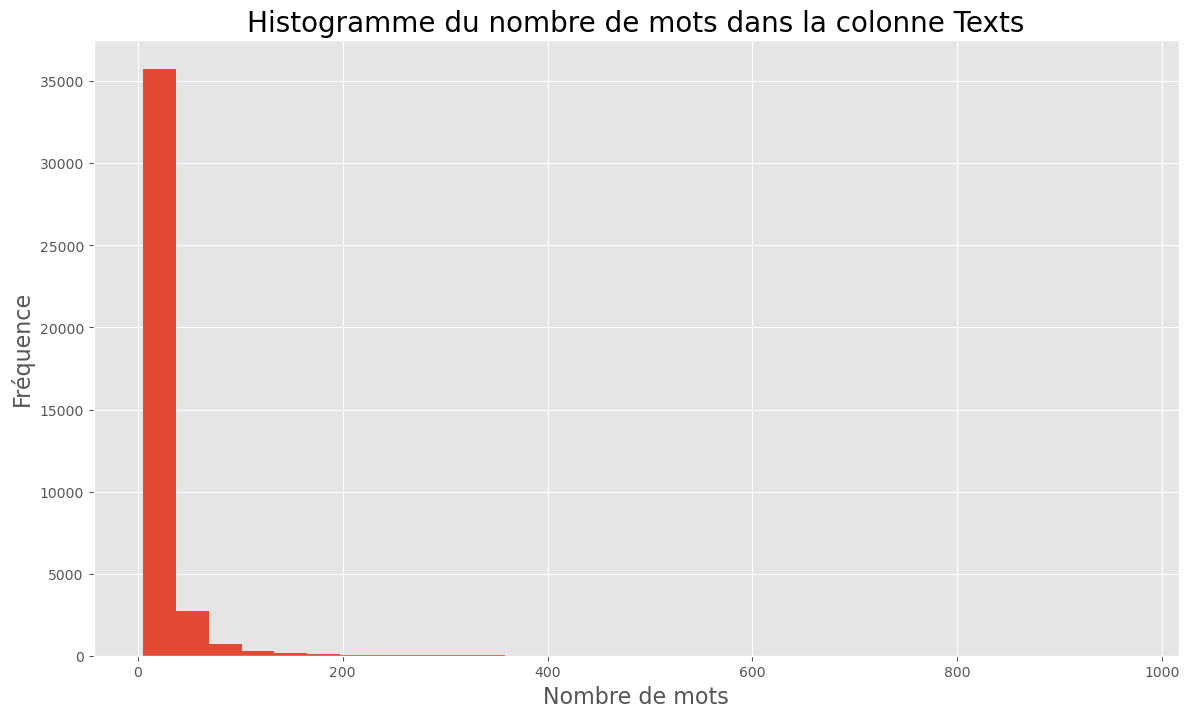

In [118]:
num_words = data_sample['Texts'].apply(lambda x: len(x))
fig = plt.figure(figsize=(14, 8))
plt.hist(num_words, bins=30)
plt.xlabel('Nombre de mots', size=16)
plt.ylabel('Fréquence', size=16)
plt.title('Histogramme du nombre de mots dans la colonne Texts', size=20)
plt.show()

Je supprime aussi les textes pour lesquels le nombre de tokens est supérieur à 100 car ils rendront difficile les calculs matriciels.

In [121]:
data_sample = data_sample[data_sample['Texts'].apply(lambda x: len(x)) <= 100]

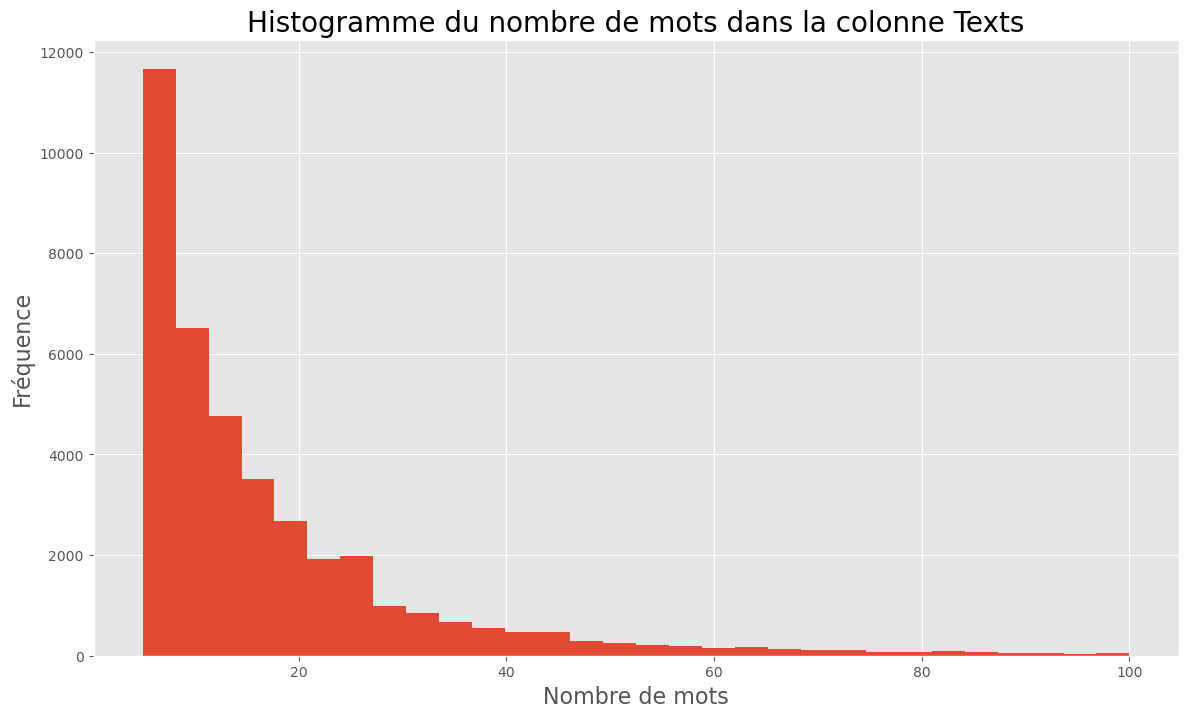

In [122]:
num_words = data_sample['Texts'].apply(lambda x: len(x))
fig = plt.figure(figsize=(14, 8))
plt.hist(num_words, bins=30)
plt.xlabel('Nombre de mots', size=16)
plt.ylabel('Fréquence', size=16)
plt.title('Histogramme du nombre de mots dans la colonne Texts', size=20)
plt.show()

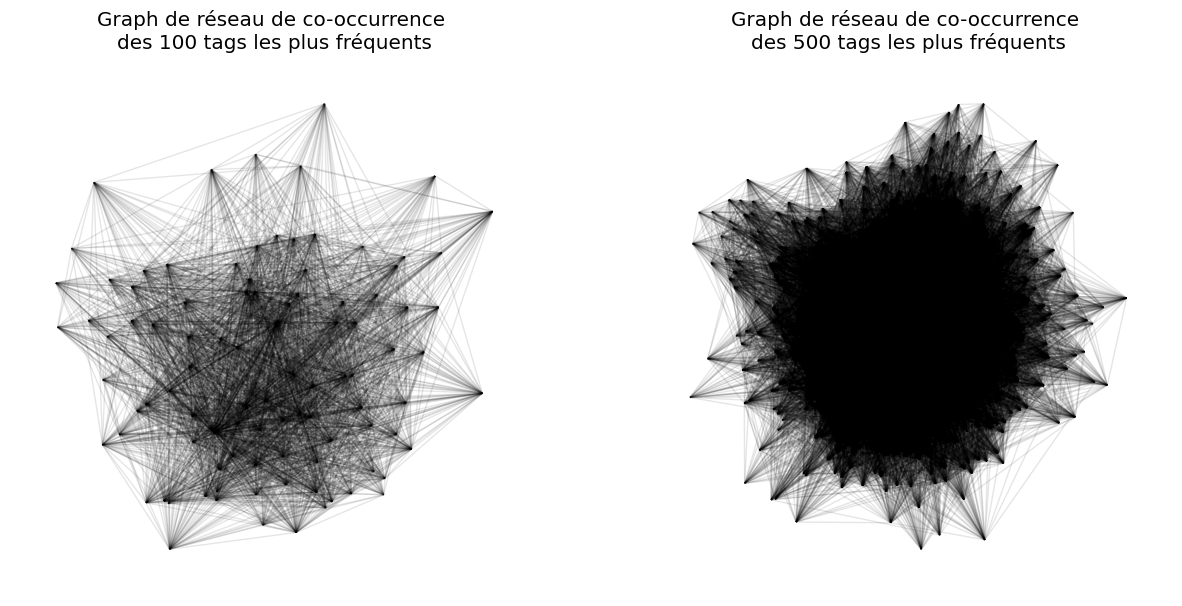

In [123]:
tag_cooccur_100 = np.zeros((100, 100))
top_tags_100 = [word for word, count in tag_counts.most_common(100)]
for tags in data_sample['Tags']:
    filtered_tags = [tag for tag in tags if tag in top_tags_100]
    for i, tag1 in enumerate(filtered_tags):
        for j, tag2 in enumerate(filtered_tags):
            if i != j:
                tag_cooccur_100[top_tags_100.index(tag1), top_tags_100.index(tag2)] += 1

tag_cooccur_500 = np.zeros((500, 500))
top_tags_500 = [word for word, count in tag_counts.most_common(500)]
for tags in data_sample['Tags']:
    filtered_tags = [tag for tag in tags if tag in top_tags_500]
    for i, tag1 in enumerate(filtered_tags):
        for j, tag2 in enumerate(filtered_tags):
            if i != j:
                tag_cooccur_500[top_tags_500.index(tag1), top_tags_500.index(tag2)] += 1

G_100 = nx.from_numpy_matrix(tag_cooccur_100)
G_500 = nx.from_numpy_matrix(tag_cooccur_500)
pos_100 = nx.spring_layout(G_100, seed=42)
pos_500 = nx.spring_layout(G_500, seed=42)

cmap = plt.cm.cool

node_colors_100 = [tag_counts[tag] for tag in G_100.nodes()]
node_sizes_100 = [tag_counts[tag]*10 for tag in G_100.nodes()]
node_colors_500 = [tag_counts[tag] for tag in G_500.nodes()]
node_sizes_500 = [tag_counts[tag]*10 for tag in G_500.nodes()]

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

nx.draw_networkx_nodes(G_100, pos_100, node_size=node_sizes_100, node_color=node_colors_100, cmap=cmap, alpha=0.7, ax=axs[0])
nx.draw_networkx_edges(G_100, pos_100, alpha=0.1, ax=axs[0])
axs[0].set_title('Graph de réseau de co-occurrence \ndes 100 tags les plus fréquents')
axs[0].axis('off')

nx.draw_networkx_nodes(G_500, pos_500, node_size=node_sizes_500, node_color=node_colors_500, cmap=cmap, alpha=0.7, ax=axs[1])
nx.draw_networkx_edges(G_500, pos_500, alpha=0.1, ax=axs[1])
axs[1].set_title('Graph de réseau de co-occurrence \ndes 500 tags les plus fréquents')
axs[1].axis('off')

plt.show()

Je peux maintenant sauvegarder ce jeu de données nettoyé pour la suite du projet.

In [124]:
data_sample.to_csv(main_path+'saved_ressources/data_cleaned_500tags.csv', index=False)